# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
reg = pd.read_csv('../../shared/problem1-reg_data.csv', sep=';')

In [3]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg.isna().any()

reg_ts    False
uid       False
dtype: bool

In [5]:
fd = pd.read_csv('../../shared/problem1-auth_data.csv', sep=';')

In [6]:
fd.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
fd.isna().any()

auth_ts    False
uid        False
dtype: bool

In [8]:
pd.to_datetime(fd['auth_ts'], unit='s').dt.date

0          1998-11-18
1          1999-07-22
2          1999-07-25
3          1999-07-31
4          1999-08-05
              ...    
9601008    2020-09-23
9601009    2020-09-23
9601010    2020-09-23
9601011    2020-09-23
9601012    2020-09-23
Name: auth_ts, Length: 9601013, dtype: object

Не имеет смысла рассматривать данные за 20 лет. За это время движок, концепция и политика игры множество раз менялись. Поймём для начала сам разброс дат

In [9]:
fd['date'] = pd.to_datetime(fd['auth_ts'], unit='s').dt.date

In [10]:
fd.head()

,auth_ts,uid,date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05


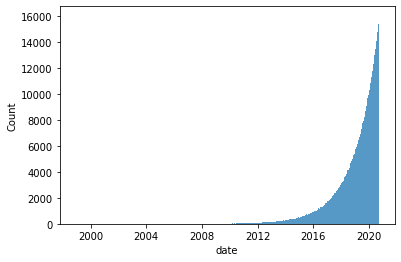

In [11]:
sns.histplot(fd.date)

In [12]:
fd.date.quantile(0.1)

datetime.date(2016, 12, 5)

In [13]:
reg['date'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.date

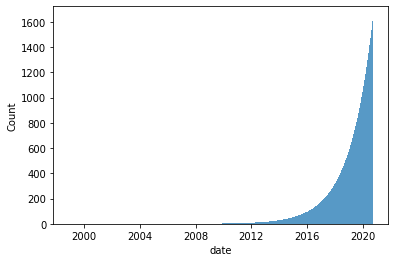

In [14]:
sns.histplot(reg.date)

In [15]:
reg.date.quantile(0.1)

datetime.date(2016, 11, 23)

Ограничемся хотя бы 2016ым годом

In [16]:
reg = reg[reg.date > dt.date(2016, 1, 1)]

In [17]:
fd = fd[fd.date > dt.date(2016, 1, 1)]

Проверим, регистрировались ли пользователи в системе дважды

In [18]:
reg.shape[0] == reg.uid.nunique()

True

Пользователь за день, мог заходить несколько раз. Нас интересует только сам факт, заходил ли пользователь за день. Уберём дубли

In [19]:
fd_group = fd.groupby(by=['uid', 'date'], as_index=False).agg({'auth_ts':'min'})

Найдём retantion n-ого дня

In [20]:
retention_n = reg.merge(fd_group, 
                        how='left', 
                        on='uid').rename(columns={'date_x':'registration', 'date_y':'visit'})

In [21]:
retention_n.head()

,reg_ts,uid,registration,visit,auth_ts
0,1451692939,64962,2016-01-02,2016-01-02,1451692939
1,1451693837,64963,2016-01-02,2016-01-02,1451693837
2,1451694736,64964,2016-01-02,2016-01-02,1451694736
3,1451695634,64966,2016-01-02,2016-01-02,1451695634
4,1451696533,64967,2016-01-02,2016-01-02,1451696533


Вообще полезно представлять динамику уникальных посещений

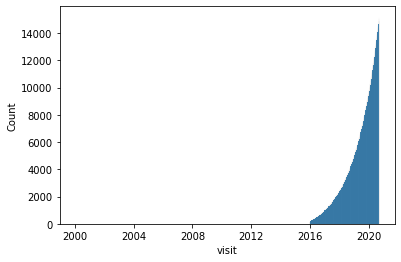

In [22]:
sns.histplot(retention_n.visit)

выше мы рисовали график, с учетом повторных посещений за день. Тренды на этих графиках не отличаются

In [23]:
retention_n.isna().any()

reg_ts          False
uid             False
registration    False
visit           False
auth_ts         False
dtype: bool

In [24]:
retention_n['days_diff'] = (retention_n.visit - retention_n.registration).dt.days

In [25]:
final_n_retention = retention_n.groupby(by='days_diff', as_index=False).agg({'uid':'count'})

Text(0, 0.5, 'uid count')

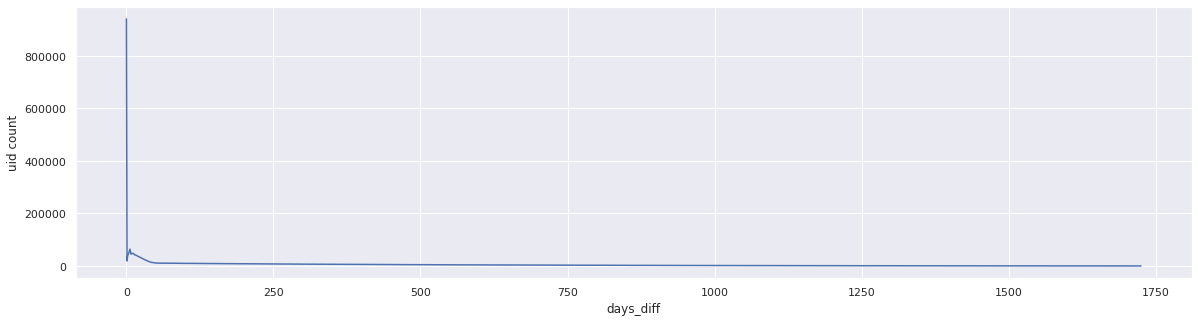

In [26]:
sns.set(rc={'figure.figsize':(20, 5)})
sns.lineplot(x=final_n_retention.days_diff, y=final_n_retention.uid).set_ylabel('uid count')

Ожидаемо, нуливой день - все пользователи (дата первого входа равна дате регистрации). Такое количество пользователей мешает смотреть на график, посмотрим без нулевого дня 

Text(0, 0.5, 'uid count')

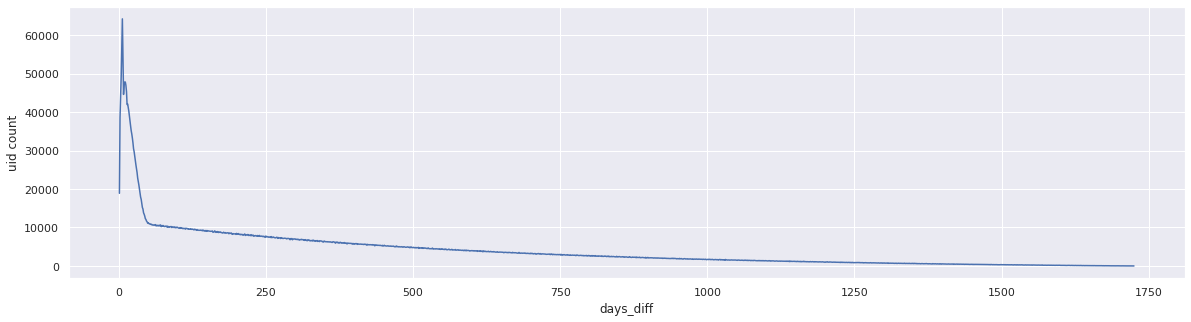

In [27]:
sns.set(rc={'figure.figsize':(20, 5)})
sns.lineplot(x=final_n_retention[final_n_retention.days_diff > 0].days_diff, 
             y=final_n_retention[final_n_retention.days_diff > 0].uid).set_ylabel('uid count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 <a list of 99 Text major ticklabel objects>)

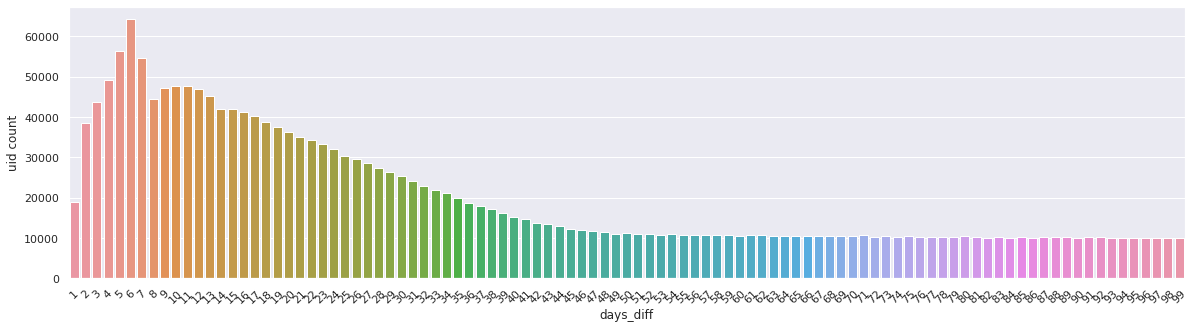

In [28]:
sns.set(rc={'figure.figsize':(20, 5)})
sns.barplot(x=final_n_retention[(final_n_retention.days_diff > 0) & 
                                (final_n_retention.days_diff < 100)].days_diff, 
            y=final_n_retention[(final_n_retention.days_diff > 0) & 
                                (final_n_retention.days_diff < 100)].uid).set_ylabel('uid count')
plt.xticks(rotation=45)

Из графика мы видим, что примерно до 14ого дня показатель посещения увеличивается, дальше резко уменьшается до 45ого дня, после чего начинает уменьшаться постепенно

Давайте посмотрим на средние значения (без учёта нулевого дня. Нулевой день - скорее показатель рекламной компании, а не качества самого продукта)

In [29]:
final_n_retention[final_n_retention.days_diff > 0].uid.mean()

3977.1953623188406

В среднем в день было 3977 пользователей, заходивших хоть раз после регистрации

In [30]:
final_n_retention[final_n_retention.days_diff > 0].uid.median()

2322.0

Посмотрим на когорты по месяцам

In [31]:
retention_n['month_visit'] = retention_n.visit.apply(lambda x: x.replace(day=1).strftime('%Y-%m-%d'))

In [32]:
retention_n['month_registration'] = retention_n.registration.apply(lambda x: 
                                                        x.replace(day=1).strftime('%Y-%m-%d'))

In [33]:
month_categories = retention_n[['month_visit', 
                                'month_registration', 
                                'uid']].pivot_table(index=['month_registration'],
                                                                    columns=['month_visit'], 
                                                                    aggfunc='count', 
                                                                    values='uid')

In [34]:
month_categories.head(20)

month_visit,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
month_registration,,,,,,,,,,,,,,,,,,,,,
2016-01-01,5005.0,2456.0,1049.0,919.0,937.0,898.0,941.0,936.0,925.0,937.0,...,923.0,934.0,879.0,944.0,940.0,925.0,935.0,941.0,931.0,675.0
2016-02-01,NaN,5050.0,2784.0,1120.0,1126.0,1094.0,1103.0,1089.0,1083.0,1112.0,...,1119.0,1116.0,1054.0,1086.0,1085.0,1124.0,1071.0,1111.0,1070.0,819.0
2016-03-01,NaN,NaN,5757.0,2933.0,1353.0,1252.0,1281.0,1269.0,1230.0,1277.0,...,1265.0,1274.0,1192.0,1314.0,1232.0,1285.0,1253.0,1249.0,1315.0,920.0
2016-04-01,NaN,NaN,NaN,5625.0,3007.0,1333.0,1302.0,1298.0,1261.0,1315.0,...,1349.0,1297.0,1221.0,1323.0,1276.0,1310.0,1250.0,1334.0,1313.0,984.0
2016-05-01,NaN,NaN,NaN,NaN,6288.0,3114.0,1414.0,1379.0,1310.0,1373.0,...,1370.0,1390.0,1296.0,1391.0,1336.0,1374.0,1325.0,1372.0,1389.0,1007.0
2016-06-01,NaN,NaN,NaN,NaN,NaN,6424.0,3661.0,1591.0,1458.0,1509.0,...,1492.0,1517.0,1437.0,1518.0,1458.0,1496.0,1442.0,1485.0,1501.0,1094.0
2016-07-01,NaN,NaN,NaN,NaN,NaN,NaN,6935.0,3865.0,1723.0,1694.0,...,1720.0,1716.0,1589.0,1665.0,1646.0,1695.0,1642.0,1681.0,1693.0,1262.0
2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7316.0,3655.0,1781.0,...,1677.0,1648.0,1559.0,1665.0,1608.0,1673.0,1603.0,1691.0,1690.0,1229.0
2016-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7321.0,3963.0,...,1691.0,1673.0,1568.0,1691.0,1603.0,1688.0,1647.0,1711.0,1711.0,1209.0


Посмотрим на когорты за последний год

In [35]:
month_categories_last_year = retention_n[(retention_n.month_visit > '2019-12-31') 
                                         & (retention_n.month_registration > '2019-12-31')]
[['month_visit', 'month_registration', 'uid']].pivot_table(index=['month_registration'], 
                                                           columns=['month_visit'], 
                                                           aggfunc='count', values='uid')

In [36]:
month_categories_last_year

month_visit,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
month_registration,,,,,,,,,
2020-01-01,56735.0,28489.0,13863.0,12740.0,13052.0,12742.0,13070.0,13082.0,9488.0
2020-02-01,NaN,54229.0,30077.0,12839.0,12644.0,12176.0,12669.0,12658.0,9342.0
2020-03-01,NaN,NaN,63079.0,32546.0,15494.0,14383.0,14832.0,14789.0,10813.0
2020-04-01,NaN,NaN,NaN,63929.0,34359.0,15179.0,15070.0,14995.0,10992.0
2020-05-01,NaN,NaN,NaN,NaN,69815.0,36492.0,17214.0,16417.0,12001.0
2020-06-01,NaN,NaN,NaN,NaN,NaN,69722.0,37778.0,16855.0,11585.0
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,77509.0,40549.0,13546.0
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81188.0,35410.0
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55810.0


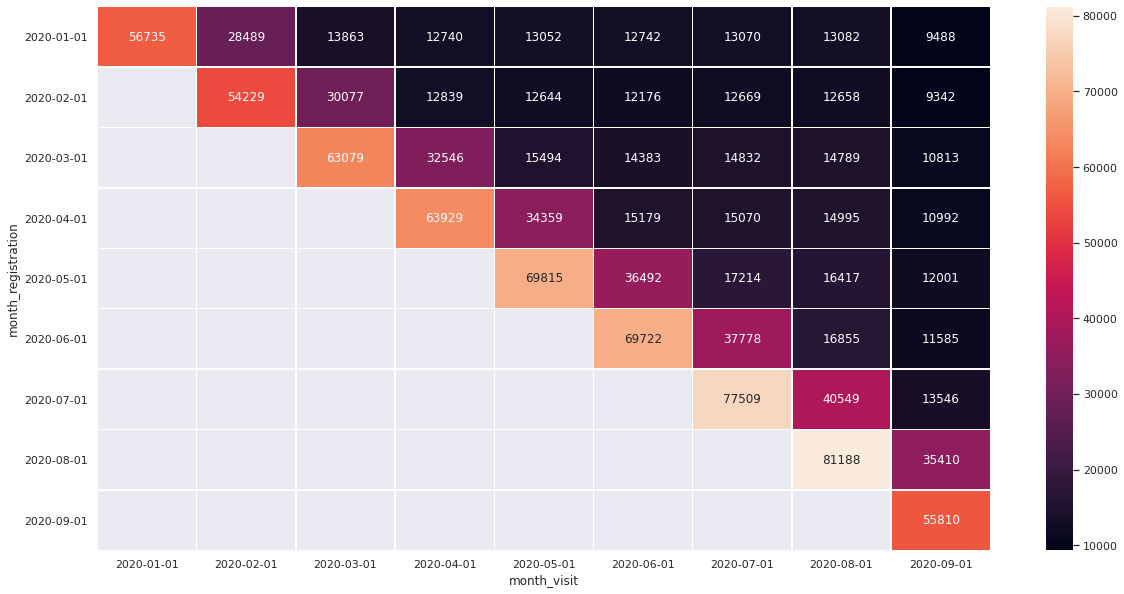

In [37]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(month_categories_last_year, annot=True, linewidth=.5, fmt=".0f")

Посчитаем для каждой когорты Retention rate (долю пользователей, которые продолжают использовать платформу). Считать её в сравнении с сегодняшнем днём нечестно, так как из более поздних когорт пользователи не успевают отвалиться. Поэтому посчитаем её за период 6 месяцев.

In [38]:
month_rr = []
for i in range(16, 21):
    for j in range(1, 13):
        if j < 10:
            if j + 6 > 12 and f'20{i+1}-0{(j+6)%12}-01' < '2020-09-01':
                month_rr.append([f'20{i}-0{j}-01', 
                                month_categories[f'20{i+1}-0{(j+6)%12}-01'][f'20{i}-0{j}-01'] * 100 / 
                                 month_categories[f'20{i}-0{j}-01'][f'20{i}-0{j}-01']])
            elif f'20{i}-{j+6}-01' < '2020-09-01' and j+6 >= 10:
                month_rr.append([f'20{i}-0{j}-01', 
                                 month_categories[f'20{i}-{j+6}-01'][f'20{i}-0{j}-01'] * 100 / 
                                 month_categories[f'20{i}-0{j}-01'][f'20{i}-0{j}-01']])
            elif f'20{i}-{j+6}-01' < '2020-09-01' and j+6 < 10:
                month_rr.append([f'20{i}-0{j}-01', 
                                 month_categories[f'20{i}-0{j+6}-01'][f'20{i}-0{j}-01'] * 100 / 
                                 month_categories[f'20{i}-0{j}-01'][f'20{i}-0{j}-01']])
        elif f'20{i+1}-0{(j+6)%12}-01' < '2020-09-01':
            month_rr.append([f'20{i}-{j}-01', 
                             month_categories[f'20{i+1}-0{(j+6)%12}-01'][f'20{i}-{j}-01'] * 100 / 
                             month_categories[f'20{i}-{j}-01'][f'20{i}-{j}-01']])

In [39]:
month_rr_df = pd.DataFrame(month_rr, columns=['month', 'rr'])

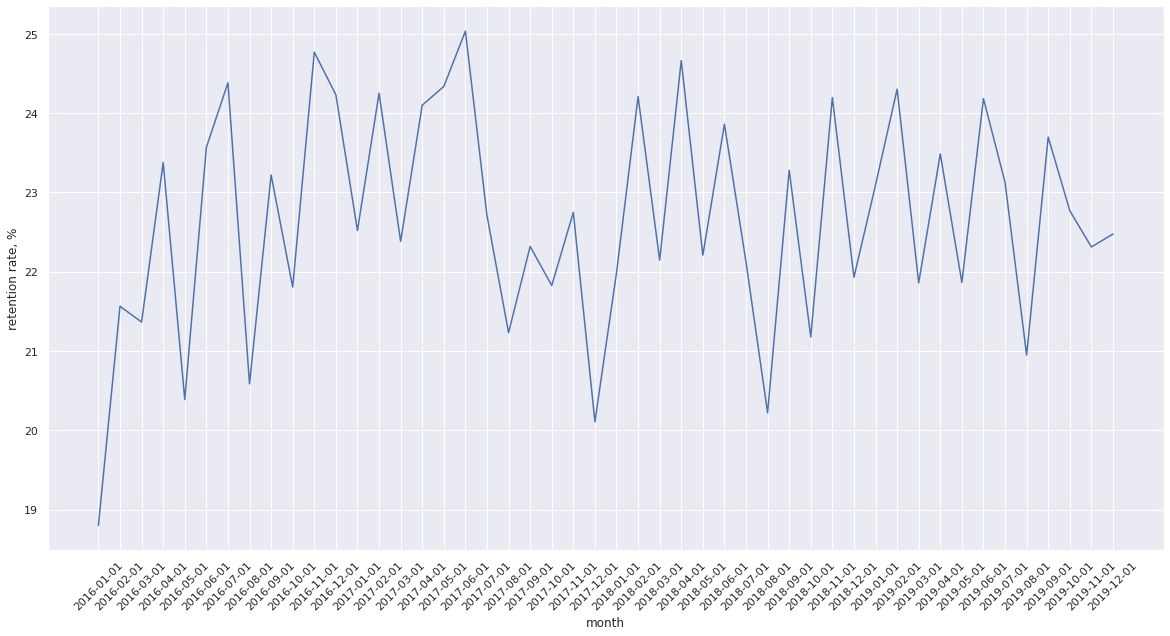

In [40]:
sns.lineplot(data=month_rr_df, x='month', y='rr').set_ylabel('retention rate, %')
dummy = plt.xticks(rotation=45)

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [41]:
df = pd.read_csv('project_1_task_2.csv', sep=';')

In [42]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [43]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [44]:
df.isna().any()

user_id      False
revenue      False
testgroup    False
dtype: bool

In [45]:
df.user_id.nunique() == df.shape[0]

True

In [46]:
df[df.testgroup == 'a'].shape[0]

202103

a - контрольная группа, b - тестовая

ARPU = (число клиентов) * (доход) / (число пользователей) *(число клиентов) = доход / число пользователей

Соответсвенно, у нас есть доходы пользователей, и мы хотим проверить гипотезу $H_0$: средние доходы пользователей не отличаются

Посмотрим на графики

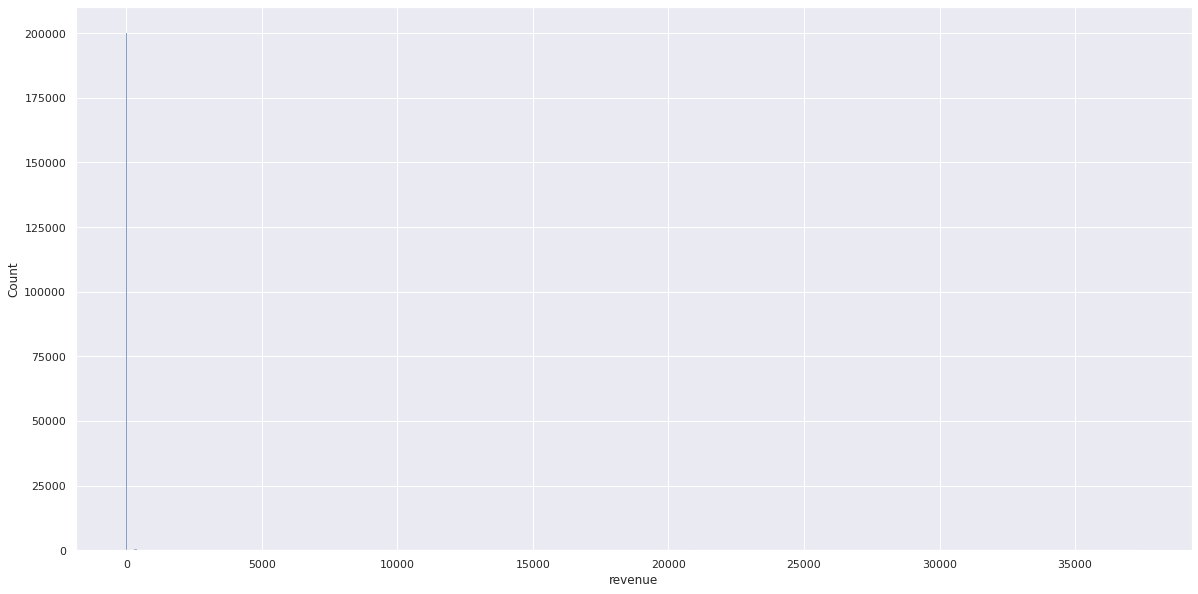

In [47]:
sns.histplot(df[df.testgroup == 'a']['revenue'], bins=1000)

из графика видно, распределение не является нормальным

In [48]:
stats.mannwhitneyu(df[df.testgroup == 'a']['revenue'], df[df.testgroup == 'b']['revenue'])

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [49]:
df[df.testgroup == 'b']['revenue'].mean()

26.75128659327863

In [50]:
df[df.testgroup == 'a']['revenue'].mean()

25.413719736965806

Для сравнения ARPU. Сделаем бутстрап

In [51]:
def boot_mean(data_1, data_2): 
    means_diff = []
    for i in range(10000):
        sample_data1 = data_1.sample(frac=1, replace=True)
        sample_mean1 = sample_data1.mean()
        sample_data2 = data_2.sample(frac=1, replace=True)
        sample_mean2 = sample_data2.mean()
        means_diff.append(sample_mean1 - sample_mean2)
    return means_diff

In [52]:
revenue_means_diff = boot_mean(df[df.testgroup == 'a']['revenue'], df[df.testgroup == 'b']['revenue'])

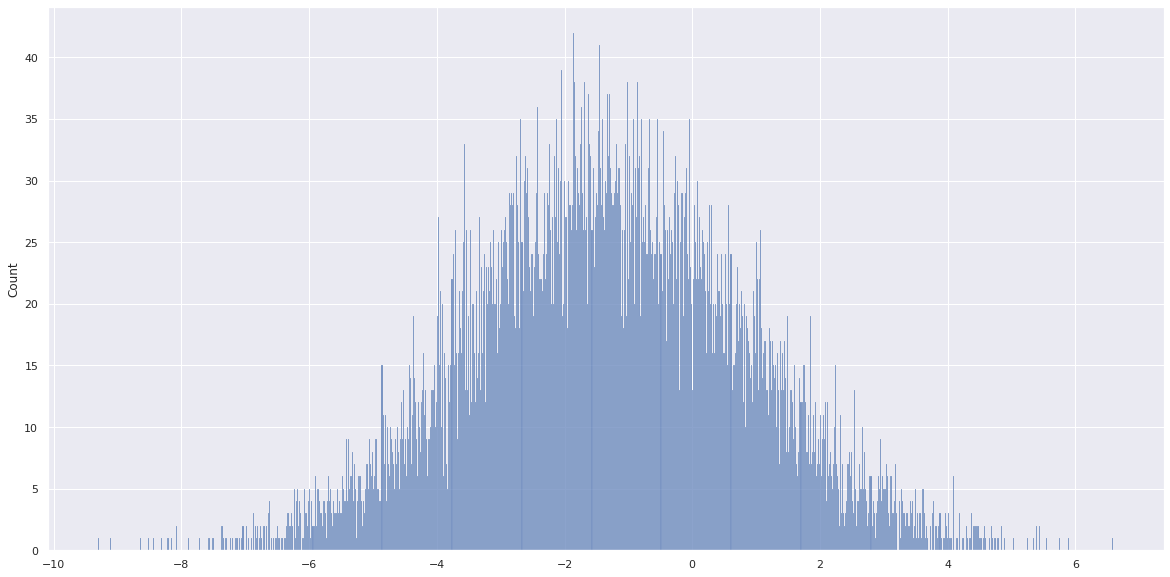

In [53]:
sns.histplot(revenue_means_diff, bins=1000)

In [54]:
print(pd.Series(revenue_means_diff).quantile(0.975))
print(pd.Series(revenue_means_diff).quantile(0.025))

2.9518513895500935
-5.470261789752636


Как видим, 0 попадает в квантиль, так что на уровне значимости 5% не будет отклонять гипотезу, о том, что средние одинаковы в пользу гипотезы, что они не равны

Однако наборы акций скорее механизм для клиентов, а не для пользователей. Поэтому рассмотрим также ARPPU. Так мы увеличим точность.

In [55]:
df_customer = df[df.revenue > 0] 

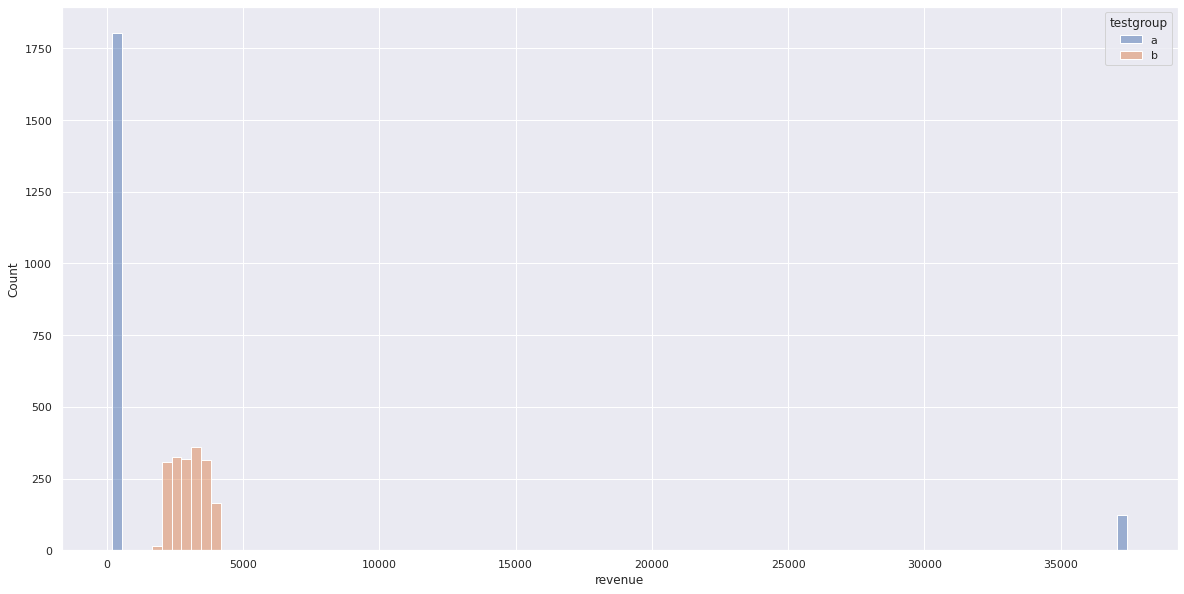

In [56]:
sns.histplot(data=df_customer, x='revenue', hue='testgroup')


Уже из графиков видно, что распределения не являются нормальными, и что они различны, давайте убедимся в этом с помощью тестов

In [57]:
stats.shapiro(df_customer[df_customer.testgroup == 'a'].revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [58]:
stats.shapiro(df_customer[df_customer.testgroup == 'b'].revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

На уровне значимости 1% распределения отличаются от нормального

In [59]:
diff_means = boot_mean(df_customer[df_customer.testgroup == 'a'].revenue,
                       df_customer[df_customer.testgroup == 'b'].revenue)

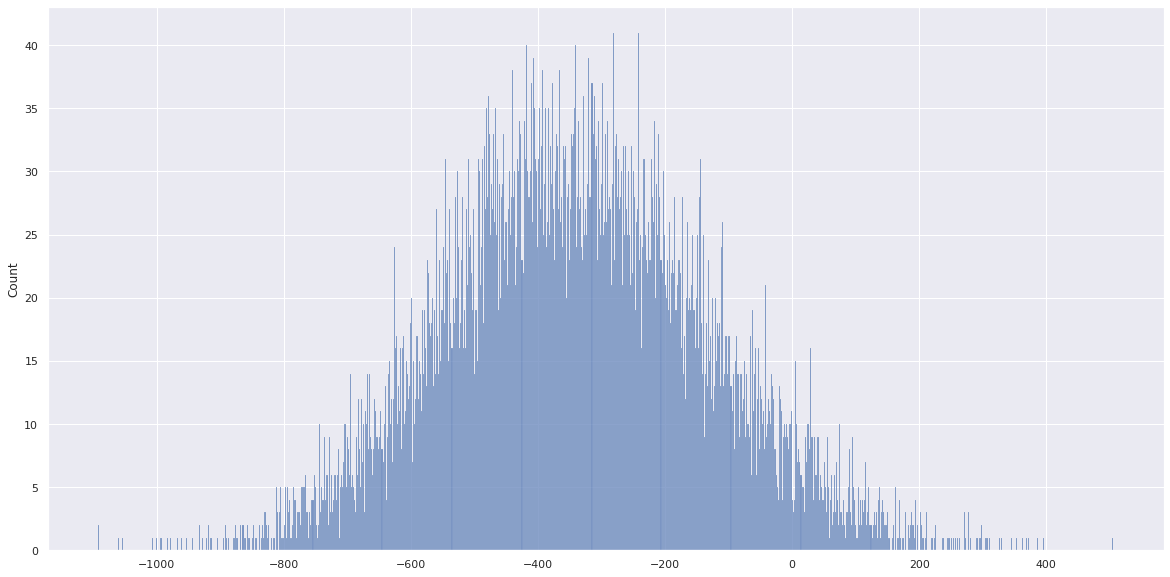

In [60]:
sns.histplot(diff_means, bins=1000)

In [61]:
print(pd.Series(diff_means).quantile(0.975))
print(pd.Series(diff_means).quantile(0.025))

73.90696437397288
-730.8839327637036


0 входит в доверительный интервал, поэтому гипотезу о равенстве ARPPU нельзя отклонять в пользу альтернативной о неравенстве

Рассмотрим также вспомогательную метрику -- среднее число пользователей, ставших клиентами. В целом, чем ближе ARPU к ARPPU, тем больше потенциал бизнеса (больше пользователей становятся клиентами)

In [62]:
df['is_customer'] = df.revenue.apply(lambda x: 1 if x > 0 else 0)

Будем считать, что пользователи переходят в контрольной группе с вероятностью $p_1$, а в тестовой -- $p_2$. Наша гипотеза, что $H_0: p_2 = p_1$ Против альтернативной $H_1: p_2 \neq p_1$. Уровень значимости возьмём 5%

Запишем z-статистику $\frac{p_2-p_1}{\sqrt{p(1-p)(\frac{1}{n_1}+\frac{1}{n_2})}}$, где $p=\frac{n_1p_1+n_2p_2}{n_1+n_2}$, а $p_1,~p_2$ являются выборочными вероятностями и соответсвенно считаются как доля активных пользователей

In [63]:
p1 = df[df.testgroup == 'a']['is_customer'].sum() / df[df.testgroup == 'a']['is_customer'].count()

In [64]:
p1 

0.009539690157988749

In [65]:
p2 = df[df.testgroup == 'b']['is_customer'].sum() / df[df.testgroup == 'b']['is_customer'].count()

In [66]:
p2

0.008906235351586593

In [67]:
n1 = df[df.testgroup == 'a']['is_customer'].count()
n2 = df[df.testgroup == 'b']['is_customer'].count()

In [68]:
p = (n1 * p1 + n2 * p2) / (n1 + n2)

In [69]:
(p2 - p1) / (p * (1 - p) * (1 / n1 + 1 / n2)) ** 0.5

-2.108028495889841

-2.108 < -1.96 Значит на уровне значимости 5% мы должны отклонить гипотезу $H_0$ в пользу альтернативной $H_1$. То есть в тестовой группе вероятность стать клиентом из пользователя меньше

Итог: в двух метриках ARPU и ARPPU на уровне значимости 5% результаты тестовой группы не отличаются от результатов контрольной. Однако на уровне значимости 5% вероятность перехода пользователя в клиенты снижается. Как итог тестовый вариант отклонить.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Можем также анализировать три метрики, разобранные выше. В качестве основной пусть будет Средний доход с пользователя, в качестве дополнительных - средний доход с активного пользователя и также конверсия из пользователя в активного пользователя. Соответсвенно для понимания резульатов ивентов - смотреть их будем за периоды ивентов. Если нас интересует сравнение старой системы событий с новой, то активного пользователя нежелательно определять по числу пройденных уровней, а нужно выбрать не связанную с этим величину, например, часы проведённые в игре, или по количеству целевых действий (например, кликам, переходам в интерфейсе). 

Если, например, в месяц событие какое-то ограниченное число дней, то мы можем брать показатели в сравнение с показателями месяца, например, отношение количества уникальных пользователей в игре за событие, к колчеству уникальных пользователей за месяц. Точно также можно смотреть не на среднюю выручку, а на отношение к месячному периоду. (Эти показатели помогут сравнивать результаты ивентов между собой, исключив остальные возможные факторы влияния на базовые метрики)

Также кроме различных метрик прибыли может быть полезна средняя продолжительность сессий; следить за ретеншином и вообще иметь представления о жизненном цикле игрока. 